Episode 100: Epsilon=0.6058
Episode 200: Epsilon=0.3670
Episode 300: Epsilon=0.2223
Episode 400: Epsilon=0.1347
Episode 500: Epsilon=0.0816
Episode 600: Epsilon=0.0494
Episode 700: Epsilon=0.0299
Episode 800: Epsilon=0.0181
Episode 900: Epsilon=0.0110
Episode 1000: Epsilon=0.0100
Path taken by the agent:
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (3, 3)]


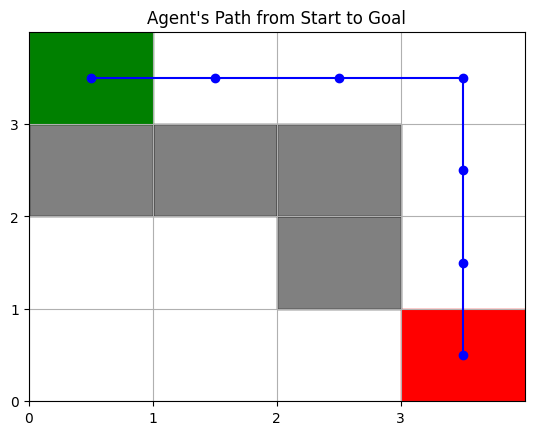

NameError: name 'path' is not defined

In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation

# Define the environment
class GridWorld:
    def __init__(self, size=(4,4), start=(0,0), goal=(3,3), obstacles=[]):
        self.size = size
        self.start = start
        self.goal = goal
        self.obstacles = obstacles
        self.reset()
        
    def reset(self):
        self.agent_pos = self.start
        return self.agent_pos
    
    def step(self, action):
        x, y = self.agent_pos
        if action == 0:   # Up
            new_pos = (x - 1, y)
        elif action == 1: # Down
            new_pos = (x + 1, y)
        elif action == 2: # Left
            new_pos = (x, y - 1)
        elif action == 3: # Right
            new_pos = (x, y + 1)
        else:
            raise ValueError("Invalid action")
        
        # Check boundaries and obstacles
        if (0 <= new_pos[0] < self.size[0]) and (0 <= new_pos[1] < self.size[1]) and (new_pos not in self.obstacles):
            self.agent_pos = new_pos
            if self.agent_pos == self.goal:
                return self.agent_pos, 1.0, True  # Reward for reaching goal
            else:
                return self.agent_pos, -0.01, False  # Small negative reward for each step
        else:
            return self.agent_pos, -1.0, False  # Penalty for invalid move

    def get_state_space(self):
        return self.size[0] * self.size[1]
    
    def get_action_space(self):
        return 4  # Up, Down, Left, Right

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, 
                 discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01):
        self.q_table = np.zeros((state_space, action_space))
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.action_space = action_space
        
    def state_to_index(self, state, grid_size):
        return state[0] * grid_size[1] + state[1]
    
    def choose_action(self, state, grid_size):
        state_index = self.state_to_index(state, grid_size)
        if random.uniform(0,1) < self.epsilon:
            return random.randint(0, self.action_space -1)  # Explore
        else:
            return np.argmax(self.q_table[state_index])  # Exploit
    
    def learn(self, state, action, reward, next_state, grid_size):
        state_index = self.state_to_index(state, grid_size)
        next_state_index = self.state_to_index(next_state, grid_size)
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.gamma * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.lr * td_error
        
    def update_epsilon(self):
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

# Training the agent
def train_agent(episodes=1000):
    env = GridWorld(obstacles=[(1,1), (2,2), (1,2), (1,0)])
    agent = QLearningAgent(state_space=env.get_state_space(), action_space=env.get_action_space())
    grid_size = env.size
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        step = 0
        while not done:
            action = agent.choose_action(state, grid_size)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state, grid_size)
            state = next_state
            step +=1
            if step > 100:  # Prevent infinite loops
                break
        agent.update_epsilon()
        if (episode+1) % 100 == 0:
            print(f"Episode {episode+1}: Epsilon={agent.epsilon:.4f}")
    return env, agent

# Testing the agent
def test_agent(env, agent, visualize=True):
    state = env.reset()
    done = False
    path = [state]
    while not done:
        action = np.argmax(agent.q_table[agent.state_to_index(state, env.size)])
        next_state, reward, done = env.step(action)
        path.append(next_state)
        state = next_state
        if len(path) > 20:
            print("Failed to reach the goal within 20 steps.")
            break
    print("Path taken by the agent:")
    print(path)
    
    if visualize:
        visualize_path(env, path)

# Visualization Function
def visualize_path(env, path):
    fig, ax = plt.subplots()
    grid_rows, grid_cols = env.size
    ax.set_xlim(0, grid_cols)
    ax.set_ylim(0, grid_rows)
    ax.set_xticks(np.arange(0, grid_cols, 1))
    ax.set_yticks(np.arange(0, grid_rows, 1))
    ax.grid(True)

    # Draw obstacles
    for obs in env.obstacles:
        rect = patches.Rectangle((obs[1], grid_rows - obs[0] -1), 1,1, linewidth=1, edgecolor='black', facecolor='gray')
        ax.add_patch(rect)
    
    # Draw start
    start = env.start
    rect = patches.Rectangle((start[1], grid_rows - start[0] -1), 1,1, linewidth=1, edgecolor='green', facecolor='green')
    ax.add_patch(rect)
    
    # Draw goal
    goal = env.goal
    rect = patches.Rectangle((goal[1], grid_rows - goal[0] -1), 1,1, linewidth=1, edgecolor='red', facecolor='red')
    ax.add_patch(rect)
    
    # Draw path
    path_x = [pos[1] + 0.5 for pos in path]
    path_y = [grid_rows - pos[0] - 0.5 for pos in path]
    ax.plot(path_x, path_y, marker='o', color='blue')
    
    plt.title("Agent's Path from Start to Goal")
    plt.show()

# Optional: Animate the agent's movement
def animate_agent(env, path):
    fig, ax = plt.subplots()
    grid_rows, grid_cols = env.size
    ax.set_xlim(0, grid_cols)
    ax.set_ylim(0, grid_rows)
    ax.set_xticks(np.arange(0, grid_cols, 1))
    ax.set_yticks(np.arange(0, grid_rows, 1))
    ax.grid(True)

    # Draw obstacles
    for obs in env.obstacles:
        rect = patches.Rectangle((obs[1], grid_rows - obs[0] -1), 1,1, linewidth=1, edgecolor='black', facecolor='gray')
        ax.add_patch(rect)
    
    # Draw start
    start = env.start
    rect = patches.Rectangle((start[1], grid_rows - start[0] -1), 1,1, linewidth=1, edgecolor='green', facecolor='green')
    ax.add_patch(rect)
    
    # Draw goal
    goal = env.goal
    rect = patches.Rectangle((goal[1], grid_rows - goal[0] -1), 1,1, linewidth=1, edgecolor='red', facecolor='red')
    ax.add_patch(rect)
    
    agent_dot, = ax.plot([], [], marker='o', color='blue', markersize=12)

    def init():
        agent_dot.set_data([], [])
        return agent_dot,

    def animate(i):
        if i < len(path):
            x = path[i][1] + 0.5
            y = grid_rows - path[i][0] - 0.5
            agent_dot.set_data(x, y)
        return agent_dot,

    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                  frames=len(path), interval=500, blit=True, repeat=False)
    plt.title("Agent's Movement Animation")
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Train the agent
    env, agent = train_agent(episodes=1000)
    
    # Test the agent and visualize the path
    test_agent(env, agent, visualize=True)
    
    # Optional: Animate the agent's movement
    # Uncomment the following line to see the animation
    animate_agent(env, path)


Episode 100: Epsilon=0.6058
Episode 200: Epsilon=0.3670
Episode 300: Epsilon=0.2223
Episode 400: Epsilon=0.1347
Episode 500: Epsilon=0.0816
Episode 600: Epsilon=0.0494
Episode 700: Epsilon=0.0299
Episode 800: Epsilon=0.0181
Episode 900: Epsilon=0.0110
Episode 1000: Epsilon=0.0100


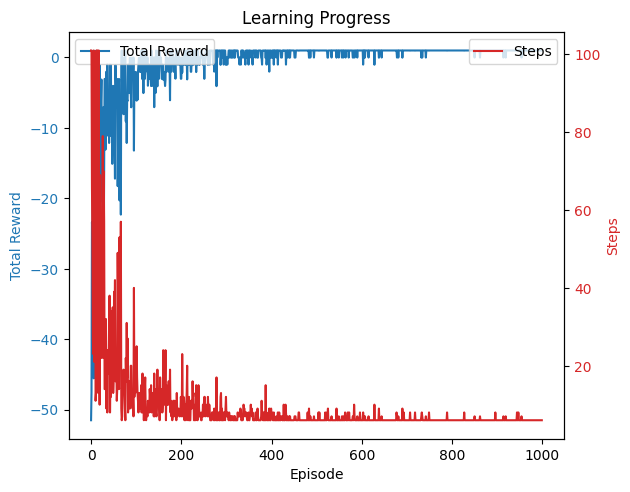

Path taken by the agent:
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (3, 3)]


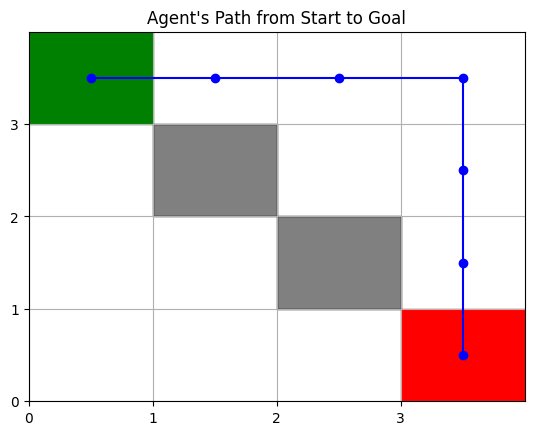

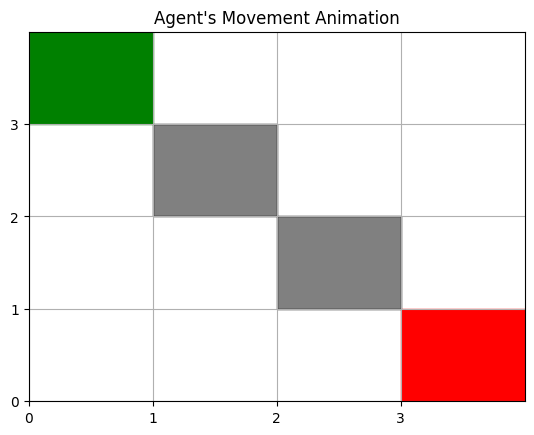

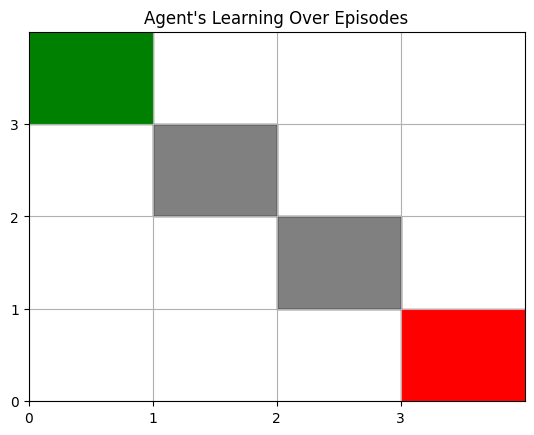

In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation

# Define the environment
class GridWorld:
    def __init__(self, size=(4,4), start=(0,0), goal=(3,3), obstacles=[]):
        self.size = size
        self.start = start
        self.goal = goal
        self.obstacles = obstacles
        self.reset()
        
    def reset(self):
        self.agent_pos = self.start
        return self.agent_pos
    
    def step(self, action):
        x, y = self.agent_pos
        if action == 0:   # Up
            new_pos = (x - 1, y)
        elif action == 1: # Down
            new_pos = (x + 1, y)
        elif action == 2: # Left
            new_pos = (x, y - 1)
        elif action == 3: # Right
            new_pos = (x, y + 1)
        else:
            raise ValueError("Invalid action")
        
        # Check boundaries and obstacles
        if (0 <= new_pos[0] < self.size[0]) and (0 <= new_pos[1] < self.size[1]) and (new_pos not in self.obstacles):
            self.agent_pos = new_pos
            if self.agent_pos == self.goal:
                return self.agent_pos, 1.0, True  # Reward for reaching goal
            else:
                return self.agent_pos, -0.01, False  # Small negative reward for each step
        else:
            return self.agent_pos, -1.0, False  # Penalty for invalid move

    def get_state_space(self):
        return self.size[0] * self.size[1]
    
    def get_action_space(self):
        return 4  # Up, Down, Left, Right

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, 
                 discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01):
        self.q_table = np.zeros((state_space, action_space))
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.action_space = action_space
        
    def state_to_index(self, state, grid_size):
        return state[0] * grid_size[1] + state[1]
    
    def choose_action(self, state, grid_size):
        state_index = self.state_to_index(state, grid_size)
        if random.uniform(0,1) < self.epsilon:
            return random.randint(0, self.action_space -1)  # Explore
        else:
            return np.argmax(self.q_table[state_index])  # Exploit
    
    def learn(self, state, action, reward, next_state, grid_size):
        state_index = self.state_to_index(state, grid_size)
        next_state_index = self.state_to_index(next_state, grid_size)
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.gamma * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.lr * td_error
        
    def update_epsilon(self):
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

# Training the agent
def train_agent(episodes=1000, track_learning=False):
    env = GridWorld(obstacles=[(1,1), (2,2)])
    agent = QLearningAgent(state_space=env.get_state_space(), action_space=env.get_action_space())
    grid_size = env.size
    
    # For tracking
    rewards_per_episode = []
    steps_per_episode = []
    paths_sample = []  # To store paths for animation (optional)
    sample_interval = max(1, episodes // 100)  # Adjust based on episodes
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        step = 0
        total_reward = 0
        while not done:
            action = agent.choose_action(state, grid_size)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state, grid_size)
            state = next_state
            step +=1
            total_reward += reward
            if step > 100:  # Prevent infinite loops
                break
        agent.update_epsilon()
        
        rewards_per_episode.append(total_reward)
        steps_per_episode.append(step)
        
        # Store some paths for animation
        if track_learning and (episode % sample_interval == 0):
            path = get_path(env, agent)
            paths_sample.append(path)
        
        if (episode+1) % 100 == 0:
            print(f"Episode {episode+1}: Epsilon={agent.epsilon:.4f}")
    return env, agent, rewards_per_episode, steps_per_episode, paths_sample

# Function to get a path using the current policy
def get_path(env, agent, max_steps=100):
    state = env.reset()
    done = False
    path = [state]
    step = 0
    while not done and step < max_steps:
        action = np.argmax(agent.q_table[agent.state_to_index(state, env.size)])
        next_state, reward, done = env.step(action)
        path.append(next_state)
        state = next_state
        step +=1
    return path

# Testing the agent
def test_agent(env, agent, visualize=True):
    state = env.reset()
    done = False
    path = [state]
    while not done:
        action = np.argmax(agent.q_table[agent.state_to_index(state, env.size)])
        next_state, reward, done = env.step(action)
        path.append(next_state)
        state = next_state
        if len(path) > 20:
            print("Failed to reach the goal within 20 steps.")
            break
    print("Path taken by the agent:")
    print(path)
    
    if visualize:
        visualize_path(env, path)
    return path  # Return path for animation

# Visualization Function for the Path
def visualize_path(env, path):
    fig, ax = plt.subplots()
    grid_rows, grid_cols = env.size
    ax.set_xlim(0, grid_cols)
    ax.set_ylim(0, grid_rows)
    ax.set_xticks(np.arange(0, grid_cols, 1))
    ax.set_yticks(np.arange(0, grid_rows, 1))
    ax.grid(True)

    # Draw obstacles
    for obs in env.obstacles:
        rect = patches.Rectangle((obs[1], grid_rows - obs[0] -1), 1,1, linewidth=1, edgecolor='black', facecolor='gray')
        ax.add_patch(rect)
    
    # Draw start
    start = env.start
    rect = patches.Rectangle((start[1], grid_rows - start[0] -1), 1,1, linewidth=1, edgecolor='green', facecolor='green')
    ax.add_patch(rect)
    
    # Draw goal
    goal = env.goal
    rect = patches.Rectangle((goal[1], grid_rows - goal[0] -1), 1,1, linewidth=1, edgecolor='red', facecolor='red')
    ax.add_patch(rect)
    
    # Draw path
    path_x = [pos[1] + 0.5 for pos in path]
    path_y = [grid_rows - pos[0] - 0.5 for pos in path]
    ax.plot(path_x, path_y, marker='o', color='blue')
    
    plt.title("Agent's Path from Start to Goal")
    plt.show()

# Animation Function for the Agent's Movement
def animate_agent(env, path):
    fig, ax = plt.subplots()
    grid_rows, grid_cols = env.size
    ax.set_xlim(0, grid_cols)
    ax.set_ylim(0, grid_rows)
    ax.set_xticks(np.arange(0, grid_cols, 1))
    ax.set_yticks(np.arange(0, grid_rows, 1))
    ax.grid(True)

    # Draw obstacles
    for obs in env.obstacles:
        rect = patches.Rectangle((obs[1], grid_rows - obs[0] -1), 1,1, linewidth=1, edgecolor='black', facecolor='gray')
        ax.add_patch(rect)
    
    # Draw start
    start = env.start
    rect = patches.Rectangle((start[1], grid_rows - start[0] -1), 1,1, linewidth=1, edgecolor='green', facecolor='green')
    ax.add_patch(rect)
    
    # Draw goal
    goal = env.goal
    rect = patches.Rectangle((goal[1], grid_rows - goal[0] -1), 1,1, linewidth=1, edgecolor='red', facecolor='red')
    ax.add_patch(rect)
    
    agent_dot, = ax.plot([], [], marker='o', color='blue', markersize=12)

    def init():
        agent_dot.set_data([], [])
        return agent_dot,

    def animate(i):
        if i < len(path):
            x = path[i][1] + 0.5
            y = grid_rows - path[i][0] - 0.5
            agent_dot.set_data(x, y)
        return agent_dot,

    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                  frames=len(path), interval=500, blit=True, repeat=False)
    plt.title("Agent's Movement Animation")
    plt.show()

# Visualization Function for Learning Progress
def plot_learning_progress(rewards, steps):
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward', color=color)
    ax1.plot(rewards, color=color, label='Total Reward')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Steps', color=color)  # We already handled the x-label with ax1
    ax2.plot(steps, color=color, label='Steps')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    fig.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.title("Learning Progress")
    plt.show()

# Optional: Animate Multiple Paths to Show Learning Over Time
def animate_learning(env, paths_sample):
    fig, ax = plt.subplots()
    grid_rows, grid_cols = env.size
    ax.set_xlim(0, grid_cols)
    ax.set_ylim(0, grid_rows)
    ax.set_xticks(np.arange(0, grid_cols, 1))
    ax.set_yticks(np.arange(0, grid_rows, 1))
    ax.grid(True)

    # Draw obstacles
    for obs in env.obstacles:
        rect = patches.Rectangle((obs[1], grid_rows - obs[0] -1), 1,1, linewidth=1, edgecolor='black', facecolor='gray')
        ax.add_patch(rect)
    
    # Draw start
    start = env.start
    rect = patches.Rectangle((start[1], grid_rows - start[0] -1), 1,1, linewidth=1, edgecolor='green', facecolor='green')
    ax.add_patch(rect)
    
    # Draw goal
    goal = env.goal
    rect = patches.Rectangle((goal[1], grid_rows - goal[0] -1), 1,1, linewidth=1, edgecolor='red', facecolor='red')
    ax.add_patch(rect)
    
    lines = []
    for _ in paths_sample:
        line, = ax.plot([], [], marker='o', linestyle='-', color='blue', alpha=0.5)
        lines.append(line)
    
    def init():
        for line in lines:
            line.set_data([], [])
        return lines

    def animate(i):
        if i < len(paths_sample):
            path = paths_sample[i]
            path_x = [pos[1] + 0.5 for pos in path]
            path_y = [grid_rows - pos[0] - 0.5 for pos in path]
            lines[i].set_data(path_x, path_y)
        return lines

    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                  frames=len(paths_sample), interval=500, blit=True, repeat=False)
    plt.title("Agent's Learning Over Episodes")
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Train the agent with learning tracking
    env, agent, rewards, steps, paths_sample = train_agent(episodes=1000, track_learning=True)
    
    # Plot learning progress
    plot_learning_progress(rewards, steps)
    
    # Test the agent and visualize the path
    final_path = test_agent(env, agent, visualize=True)
    
    # Animate the final path
    animate_agent(env, final_path)
    
    # Optional: Animate learning progress (requires paths_sample to have stored paths)
    # Uncomment the following line to see the learning animation
    animate_learning(env, paths_sample)


Episode 100: Epsilon=0.6058
Episode 200: Epsilon=0.3670
Episode 300: Epsilon=0.2223
Episode 400: Epsilon=0.1347
Episode 500: Epsilon=0.0816
Episode 600: Epsilon=0.0494
Episode 700: Epsilon=0.0299
Episode 800: Epsilon=0.0181
Episode 900: Epsilon=0.0110
Episode 1000: Epsilon=0.0100


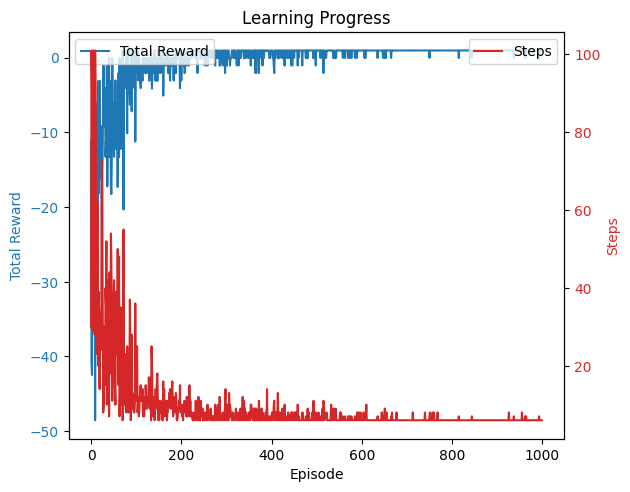

Path taken by the agent:
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (3, 3)]


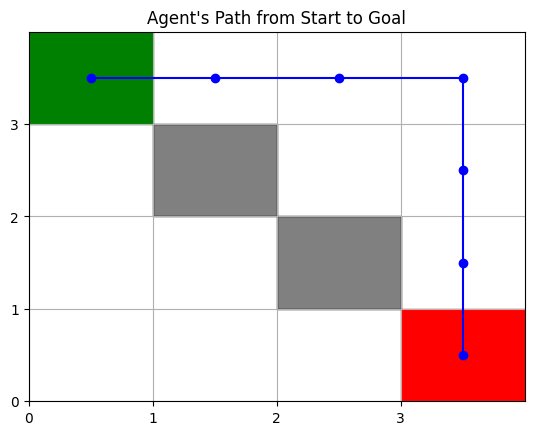

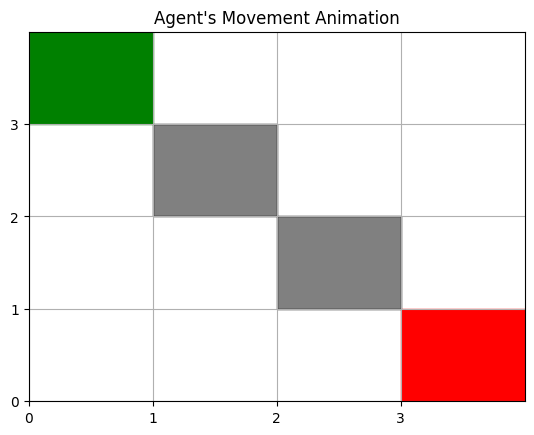

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation

# Define the environment
class GridWorld:
    def __init__(self, size=(4,4), start=(0,0), goal=(3,3), obstacles=[]):
        self.size = size
        self.start = start
        self.goal = goal
        self.obstacles = obstacles
        self.reset()
        
    def reset(self):
        self.agent_pos = self.start
        return self.agent_pos
    
    def step(self, action):
        x, y = self.agent_pos
        if action == 0:   # Up
            new_pos = (x - 1, y)
        elif action == 1: # Down
            new_pos = (x + 1, y)
        elif action == 2: # Left
            new_pos = (x, y - 1)
        elif action == 3: # Right
            new_pos = (x, y + 1)
        else:
            raise ValueError("Invalid action")
        
        # Check boundaries and obstacles
        if (0 <= new_pos[0] < self.size[0]) and (0 <= new_pos[1] < self.size[1]) and (new_pos not in self.obstacles):
            self.agent_pos = new_pos
            if self.agent_pos == self.goal:
                return self.agent_pos, 1.0, True  # Reward for reaching goal
            else:
                return self.agent_pos, -0.01, False  # Small negative reward for each step
        else:
            return self.agent_pos, -1.0, False  # Penalty for invalid move

    def get_state_space(self):
        return self.size[0] * self.size[1]
    
    def get_action_space(self):
        return 4  # Up, Down, Left, Right

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, 
                 discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01):
        self.q_table = np.zeros((state_space, action_space))
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.action_space = action_space
        
    def state_to_index(self, state, grid_size):
        return state[0] * grid_size[1] + state[1]
    
    def choose_action(self, state, grid_size):
        state_index = self.state_to_index(state, grid_size)
        if random.uniform(0,1) < self.epsilon:
            return random.randint(0, self.action_space -1)  # Explore
        else:
            return np.argmax(self.q_table[state_index])  # Exploit
    
    def learn(self, state, action, reward, next_state, grid_size):
        state_index = self.state_to_index(state, grid_size)
        next_state_index = self.state_to_index(next_state, grid_size)
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.gamma * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.lr * td_error
        
    def update_epsilon(self):
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

# Function to get a path using the current policy
def get_path(env, agent, max_steps=100):
    state = env.reset()
    done = False
    path = [state]
    step = 0
    while not done and step < max_steps:
        action = np.argmax(agent.q_table[agent.state_to_index(state, env.size)])
        next_state, reward, done = env.step(action)
        path.append(next_state)
        state = next_state
        step +=1
    return path

# Training the agent
def train_agent(episodes=1000, track_learning=False):
    env = GridWorld(obstacles=[(1,1), (2,2)])
    agent = QLearningAgent(state_space=env.get_state_space(), action_space=env.get_action_space())
    grid_size = env.size
    
    # For tracking
    rewards_per_episode = []
    steps_per_episode = []
    paths_sample = []  # To store paths for animation (optional)
    sample_interval = max(1, episodes // 100)  # Adjust based on episodes
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        step = 0
        total_reward = 0
        while not done:
            action = agent.choose_action(state, grid_size)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state, grid_size)
            state = next_state
            step +=1
            total_reward += reward
            if step > 100:  # Prevent infinite loops
                break
        agent.update_epsilon()
        
        rewards_per_episode.append(total_reward)
        steps_per_episode.append(step)
        
        # Store some paths for animation
        if track_learning and (episode % sample_interval == 0):
            path = get_path(env, agent)
            paths_sample.append(path)
        
        if (episode+1) % 100 == 0:
            print(f"Episode {episode+1}: Epsilon={agent.epsilon:.4f}")
    return env, agent, rewards_per_episode, steps_per_episode, paths_sample

# Testing the agent
def test_agent(env, agent, visualize=True):
    state = env.reset()
    done = False
    path = [state]
    while not done:
        action = np.argmax(agent.q_table[agent.state_to_index(state, env.size)])
        next_state, reward, done = env.step(action)
        path.append(next_state)
        state = next_state
        if len(path) > 20:
            print("Failed to reach the goal within 20 steps.")
            break
    print("Path taken by the agent:")
    print(path)
    
    if visualize:
        visualize_path(env, path)
    return path  # Return path for animation

# Visualization Function for the Path
def visualize_path(env, path):
    fig, ax = plt.subplots()
    grid_rows, grid_cols = env.size
    ax.set_xlim(0, grid_cols)
    ax.set_ylim(0, grid_rows)
    ax.set_xticks(np.arange(0, grid_cols, 1))
    ax.set_yticks(np.arange(0, grid_rows, 1))
    ax.grid(True)

    # Draw obstacles
    for obs in env.obstacles:
        rect = patches.Rectangle((obs[1], grid_rows - obs[0] -1), 1,1, linewidth=1, edgecolor='black', facecolor='gray')
        ax.add_patch(rect)
    
    # Draw start
    start = env.start
    rect = patches.Rectangle((start[1], grid_rows - start[0] -1), 1,1, linewidth=1, edgecolor='green', facecolor='green')
    ax.add_patch(rect)
    
    # Draw goal
    goal = env.goal
    rect = patches.Rectangle((goal[1], grid_rows - goal[0] -1), 1,1, linewidth=1, edgecolor='red', facecolor='red')
    ax.add_patch(rect)
    
    # Draw path
    path_x = [pos[1] + 0.5 for pos in path]
    path_y = [grid_rows - pos[0] - 0.5 for pos in path]
    ax.plot(path_x, path_y, marker='o', color='blue')
    
    plt.title("Agent's Path from Start to Goal")
    plt.show()

# Animation Function for the Agent's Movement
def animate_agent(env, path):
    fig, ax = plt.subplots()
    grid_rows, grid_cols = env.size
    ax.set_xlim(0, grid_cols)
    ax.set_ylim(0, grid_rows)
    ax.set_xticks(np.arange(0, grid_cols, 1))
    ax.set_yticks(np.arange(0, grid_rows, 1))
    ax.grid(True)

    # Draw obstacles
    for obs in env.obstacles:
        rect = patches.Rectangle((obs[1], grid_rows - obs[0] -1), 1,1, linewidth=1, edgecolor='black', facecolor='gray')
        ax.add_patch(rect)
    
    # Draw start
    start = env.start
    rect = patches.Rectangle((start[1], grid_rows - start[0] -1), 1,1, linewidth=1, edgecolor='green', facecolor='green')
    ax.add_patch(rect)
    
    # Draw goal
    goal = env.goal
    rect = patches.Rectangle((goal[1], grid_rows - goal[0] -1), 1,1, linewidth=1, edgecolor='red', facecolor='red')
    ax.add_patch(rect)
    
    agent_dot, = ax.plot([], [], marker='o', color='blue', markersize=12)

    def init():
        agent_dot.set_data([], [])
        return agent_dot,

    def animate(i):
        if i < len(path):
            x = path[i][1] + 0.5
            y = grid_rows - path[i][0] - 0.5
            agent_dot.set_data(x, y)
        return agent_dot,

    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                  frames=len(path), interval=500, blit=True, repeat=False)
    plt.title("Agent's Movement Animation")
    plt.show()

# Visualization Function for Learning Progress
def plot_learning_progress(rewards, steps):
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward', color=color)
    ax1.plot(rewards, color=color, label='Total Reward')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Steps', color=color)  # We already handled the x-label with ax1
    ax2.plot(steps, color=color, label='Steps')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    fig.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.title("Learning Progress")
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Train the agent with learning tracking
    env, agent, rewards, steps, paths_sample = train_agent(episodes=1000, track_learning=True)
    
    # Plot learning progress
    plot_learning_progress(rewards, steps)
    
    # Test the agent and visualize the path
    final_path = test_agent(env, agent, visualize=True)
    
    # Animate the final path
    animate_agent(env, final_path)
